### Basic spatial data handling in Python via Jupyterhub

This is a Jupyter Notebook. It consists of *Markdown* cells for formatted text, and *Code* cells, which tell the server to actually **do computations** as you click on > 'Run this cell' (Shift+Enter).

In the first *Code* cell, below, we will load a module call 'os' and use it to inspect the file system of our account on the server

In [34]:
import os
os.getcwd() # get current working directory

'/home/jovyan/teaching/heat'

In [ ]:
os.listdir("./data") # list all files in the "/data" folder

There is a .tif file, a spatial raster, in the data folder. How can we load this type of data in Python? Well... there are several options. In plain Python, without any additional modules, this would be very cumbersome. GDAL could be used, which is very fast but also quite oldschool, with difficult syntax. Rasterio is a so-called wrapper around GDAL, meaning that it uses GDAL functionality under the hood, but wrapped in somewhat easier code.

In [43]:
import rasterio

my_file = "./data/T2M_daily_mean_max_topography_2011_2020_present_30.tif"

with rasterio.open(my_file) as src:
    data = src.read()
    transform = src.transform
    crs = src.crs
    height, width = data.shape[1], data.shape[2]

# an f-string allows to print text and interpret elements in {}
print(f"height and width of the provided data are {height, width}")
print(f"The CRS is {crs}, and the transformation parameters:")
print(transform)


height and width of the provided data are (2007, 2007)
The CRS is EPSG:32633, and the transformation parameters:
| 30.00, 0.00, 360092.00|
| 0.00,-30.00, 5849845.00|
| 0.00, 0.00, 1.00|


In [40]:
print(data)

[[[0.20755936 0.20944615 0.20944615 ... 0.04558402 0.04575559 0.04579287]
  [0.20648225 0.20815457 0.20724842 ... 0.04581058 0.04604802 0.0462719 ]
  [0.2079793  0.20590611 0.20552893 ... 0.04559795 0.04562388 0.04549786]
  ...
  [0.27248257 0.27248257 0.27248257 ... 0.         0.         0.        ]
  [0.27248257 0.27248257 0.27248257 ... 0.         0.         0.        ]
  [0.27248257 0.27248257 0.27248257 ... 0.         0.         0.        ]]]


In [41]:
print(f"The shape of 'data' is {data.shape}")
print(f"The shape of 'data.squeeze()' is {data.squeeze().shape}")

The shape of 'data' is (1, 2007, 2007)
The shape of 'data.squeeze()' is (2007, 2007)


A basic module for visualisation in Python is matplotlib.pyplot, which, by convention, is imported as 'plt'. The 'imshow' function works for 2-dimensional data

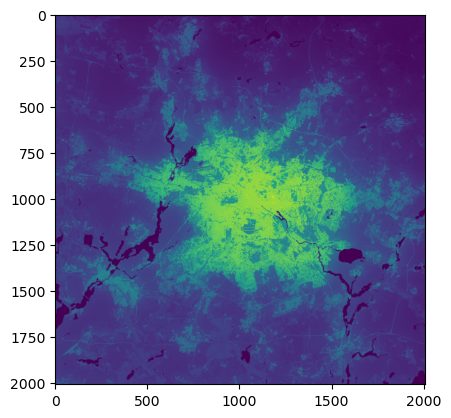

In [42]:
import matplotlib.pyplot as plt
plt.imshow(data.squeeze())

As we can see, the image looks like Berlin, with the Müggelsee and Havel visible. The axis ticks seem to correspond to height and width (2007 raster cells). There is still a simpler way for us to code this, by using a Python module with higher abstraction level.

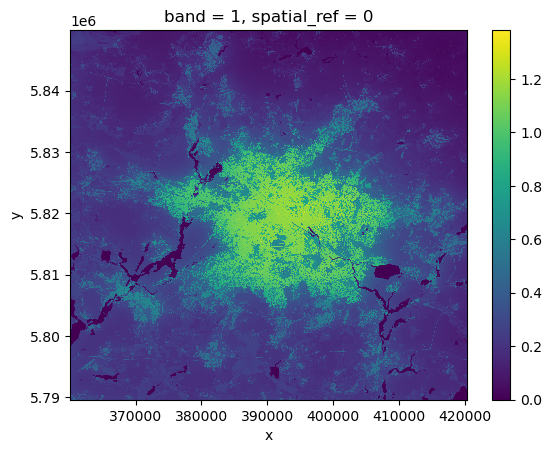

In [17]:
import rioxarray

heat_raster = rioxarray.open_rasterio(my_file)
heat_raster.plot()

Not only was the code above shorter and easier to understand - but we also get a color bar and spatial coordinates along the axes.

Now, how about vector data? The module 'geopandas', a geospatial version of the tabular data library 'pandas', is likely the first choice for handling vector data in Python

In [19]:
import geopandas as gpd

berlin = gpd.read_file("./data/berlin.gpkg")
berlin.explore()#tiles="CartoDB positron")

Interactive visualization, powered by leaflet, is very convenient. However, it does get tricky in Python when combining raster and vector data!
We will need to install an additional module, which is not part of the HU Jupyterhub setup. This can be done by "%pip install {module name}"

In [ ]:
%pip install cartopy

In [71]:
print("CRS of the raster file:", heat_raster.rio.crs)
print("CRS of the vector file:", berlin.crs)

CRS of the raster file: EPSG:32633
CRS of the vector file: EPSG:32633


In [72]:
berlin = berlin.to_crs(32633)
print("CRS of the raster file:", heat_raster.rio.crs)
print("CRS of the vector file:", berlin.crs)

CRS of the raster file: EPSG:32633
CRS of the vector file: EPSG:32633


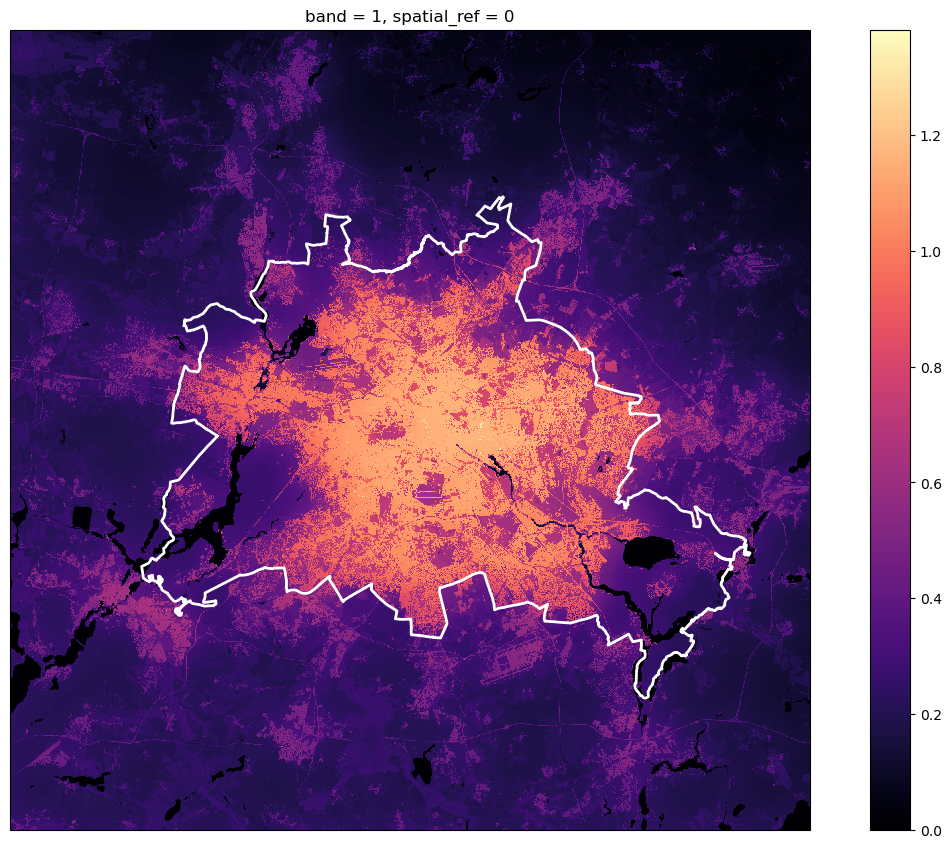

In [73]:
import cartopy.crs as ccrs

fig=plt.figure(figsize=[12,8])
ax = fig.add_axes([0,0,1,1],projection=ccrs.UTM(32))
raster_image=heat_raster.plot(ax=ax, cmap="magma")
berlin.plot(ax=ax,color='none', edgecolor="white",linewidth=2)
plt.show()

In [76]:
from rasterio.features import rasterize
help(rasterize)

/opt/conda/lib/python3.12/site-packages/rasterio/features.py:336: ShapeSkipWarning: Invalid or empty shape 1 at index 1 will not be rasterized.
  warnings.warn(


In [79]:
rasterized = rasterize(
        (berlin.geometry[0], 1),
        out_shape=heat_raster.shape[1:],
        transform=heat_raster.rio.transform(),
        fill=0,
        all_touched=True
    )

Help on function rasterize in module rasterio.features:

rasterize(shapes, out_shape=None, fill=0, nodata=None, masked=False, out=None, transform=Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), all_touched=False, merge_alg=<MergeAlg.replace: 'REPLACE'>, default_value=1, dtype=None, skip_invalid=True, dst_path=None, dst_kwds=None)
    Return an image array with input geometries burned in.

    Warnings will be raised for any invalid or empty geometries, and
    an exception will be raised if there are no valid shapes
    to rasterize.

    Parameters
    ----------
    shapes : iterable of (`geometry`, `value`) pairs or geometries
        The `geometry` can either be an object that implements the geo
        interface or GeoJSON-like object. If no `value` is provided
        the `default_value` will be used. If `value` is `None` the
        `fill` value will be used.
    out_shape : tuple or list with 2 integers
        Shape of output :class:`numpy.ndarray`.
    fill : int or float, optio

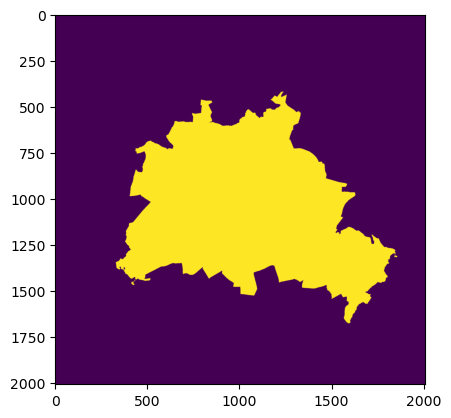

In [77]:
plt.imshow(rasterized)

In [70]:
with rasterio.open(
    "./data/berlin_rasterized.tif", # filename
    'w',                            # open in 'write' mode
    driver='GTiff',                 # file type
    height=height,                  # size of dimension 1
    width=width,                    # size of dimention 2
    count=1,                        # size of dimension 3 (layers)
    dtype=data.dtype,               # data type, e.g. byte, int8, float32
    crs=crs,                        # coordinate reference system
    transform=transform             # geotransformation parameters
) as dst:
    dst.write(rasterized, 1)        # data to write into that file

Now we know how to do a few basic things. Code that is likely to be used often can be outsourced to functions (like in R). The provided script "customFunctions.py" contains some functions to be used in the remainder of this exercise. If the script is in the same folder as *this* notebook, the functions can be imported like any official module

In [85]:
from customFunctions import writeRaster
help(writeRaster)

Help on function writeRaster in module customFunctions:

writeRaster(data, output_path, transform, crs)
    Write a numpy array to a GeoTIFF file.

